# Multiple Kernel Learning
Research - Caio<>Nicholas

## 0. Import

In [1]:
using Statistics

In [2]:
using Pkg

In [3]:
include("../data/get_data.jl")
using .GetData: get_iris_data, get_adult_data

In [4]:
X_train, y_train, X_test, y_test = get_iris_data()

([-0.881336942370561 0.9796561672173504; -0.881336942370561 1.6501432778604033; … ; 0.6328542802044121 0.3091690565742975; -0.18247945502826546 1.6501432778604033], [1, 1, -1, -1, -1, -1, 1, -1, -1, -1  …  1, 1, 1, -1, 1, -1, -1, 1, -1, 1], [-1.114289438151325 -1.255300868259494; 2.147045502779384 -0.13782235052107178; … ; 1.2152355196563247 0.08567335302661286; -0.4154319508090306 -1.4787965718071787], [-1, -1, -1, 1, -1, -1, -1, 1, -1, -1  …  1, -1, -1, -1, -1, 1, -1, -1, -1, -1])

## 1. Simple SVM - Iris Dataset 2D

In [5]:
include("../src/SVM/svm.jl")
include("../src/SVM/plot_svm.jl")
using .SVM: compute_bias, predict_svm, kernel, train_svm
using .PlotSVM: meshgrid, plot_decision_boundary

### 1.1 Preprocess Iris Data


Kernel Type: linear
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


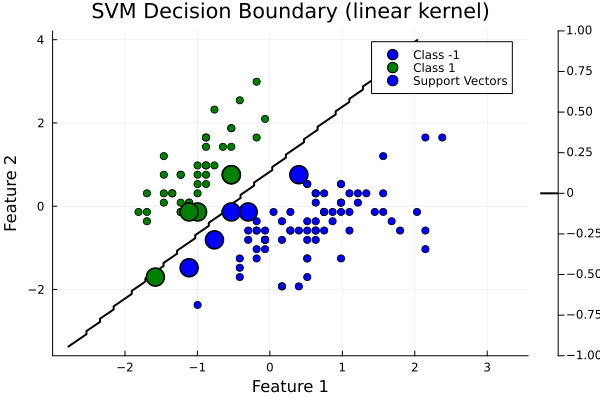


Kernel Type: polynomial
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 100.0 %
Testing Accuracy: 100.0 %


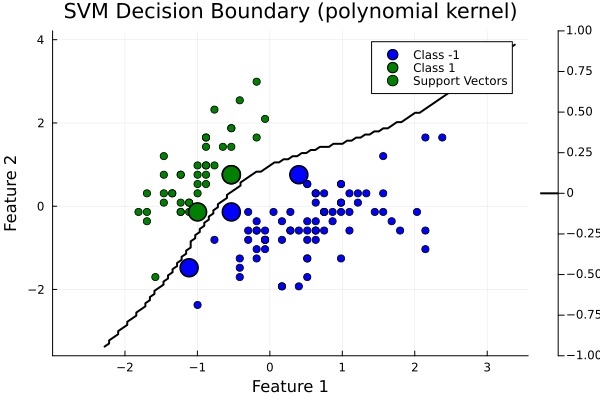


Kernel Type: rbf
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


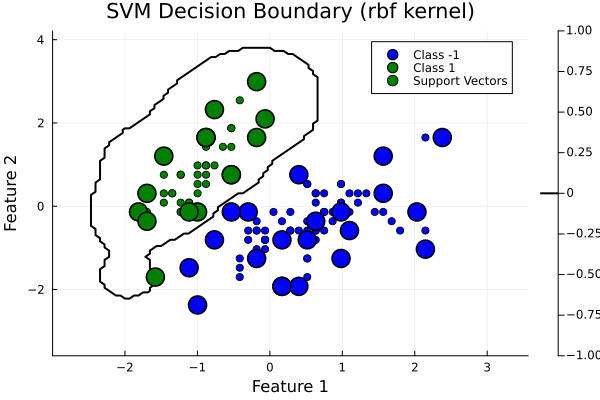

In [6]:
# Training parameters
C = 1.0
kernel_types = ["linear", "polynomial", "rbf"]  # List of kernels to test

for kernel_type in kernel_types
    println("\nKernel Type: $kernel_type")

    if kernel_type == "polynomial"
        degree = 3  # You can vary this
        γ = nothing  # Not used for polynomial
    elseif kernel_type == "rbf"
        γ = 2.0     # You can vary this
        degree = nothing  # Not used for RBF
    else
        degree = nothing
        γ = nothing
    end

    # Train the SVM model
    α, K_train = train_svm(X_train, y_train, C, kernel_type; degree=degree, gamma=γ)

    # Compute the bias term b
    b = compute_bias(α, y_train, K_train, C)

    # Make predictions on the training set
    y_pred_train = predict_svm(α, y_train, X_train, X_train, b, kernel_type;
                               degree=degree, gamma=γ)
    

    # Calculate training accuracy
    train_accuracy = mean(y_pred_train .== y_train) * 100
    println("Training Accuracy: $train_accuracy %")

    # Make predictions on the testing set
    y_pred_test = predict_svm(α, y_train, X_train, X_test, b, kernel_type;
                              degree=degree, gamma=γ)

    # Calculate testing accuracy
    test_accuracy = mean(y_pred_test .== y_test) * 100
    println("Testing Accuracy: $test_accuracy %")

    # Plot the decision boundary
    plot_decision_boundary(α, b, X_train, y_train, kernel_type; degree=degree, gamma=γ)
end

## Multi-kernel Learning

In [7]:
include("../src/MKL/multi_kernel.jl")
include("../src/MKL/plot_mkl.jl")
using .MKL: compute_kernels, train_mkl, compute_bias, predict_mkl
using .PlotMKL: plot_mkl_decision_boundary

Iteration 1...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 2...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 3...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Converged after 3 iterations.
  1.037190 seconds (1.49 M allocations: 121.341 MiB, 5.75% gc time, 80.68% compilation time)
K_combined_new dimensions: (40, 120)
K_combined_new dimensions: (40, 30)
Training Accuracy: 100.0%
Test Accuracy: 100.0%
K_combined_new dimensions: (40, 90000)


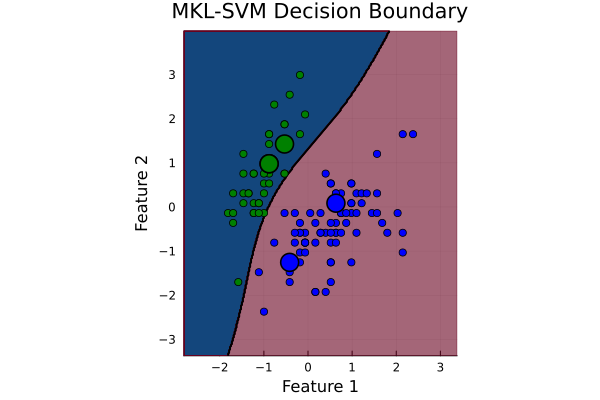

In [8]:
# Define parameters
C = 0.01
λ = 1  # Regularization for β
max_iter = 100
tolerance = 1e-3

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5))
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)


# Train MKL-SVM
@time begin
α, β, K_combined, list_alphas, list_betas = train_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train; kernel_type="precomputed", tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test; kernel_type="precomputed", tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

In [9]:
sum(α)

0.38115130988952484

## Interpretable Multi Kernel Learning

In [10]:
include("../src/MKL/multi_kernel.jl")
include("../src/MKL/plot_mkl.jl")
using .MKL: compute_kernels, train_mkl, compute_bias, predict_mkl, compute_combined_kernel
using .PlotMKL: plot_mkl_decision_boundary

include("../src/Interpretable_MKL/interpretable_multi_kernel.jl")
using .InterpretableMKL: sparse_optimize_beta, train_interpretable_mkl

In [11]:
include("../src/Interpretable_MKL/gssp.jl")

Main.GSSPAlgorithm

## Completing the Square in the MKL Objective

We focus on the \(\beta\)-dependent term:
$$
-\tfrac{1}{2}\,(y \circ \alpha)^{\top}\!\Bigl(\sum_{i=1}^q \beta_i\,K_i\Bigr)\!(y \circ \alpha)
\;+\;\lambda\,\|\beta\|_2^2.
$$

Let 
$$
v_i \;=\;(y \circ \alpha)^\top\,K_i\,(y \circ \alpha),
\quad
\text{so the expression becomes}
\quad
-\tfrac12 \sum_{i=1}^q \beta_i\,v_i \;+\;\lambda \sum_{i=1}^q \beta_i^2.
$$

Completing the square for each coordinate:
$$
\lambda\,\beta_i^2 - \tfrac{v_i}{2}\,\beta_i
\;=\;
\lambda\Bigl(\beta_i - \tfrac{v_i}{4\,\lambda}\Bigr)^2
\;-\;\tfrac{v_i^2}{16\,\lambda}.
$$

Summing over $i=1,\dots,q$ yields
$$
-\tfrac12 \sum_{i=1}^q \beta_i\,v_i \;+\;\lambda \sum_{i=1}^q \beta_i^2
\;=\;
\lambda\,\|\boldsymbol{\beta} - \boldsymbol{w}\|_2^2
\;-\;\tfrac{1}{16\,\lambda}\,\|\boldsymbol{v}\|_2^2,
\quad
\text{where}
\quad
w_i \;=\;\tfrac{v_i}{4\,\lambda}.
$$

Thus, up to the constant 
$-\,\tfrac{1}{16\,\lambda}\|\boldsymbol{v}\|_2^2$, the $\beta\$-term is
$$
\lambda\\|\boldsymbol{\beta} - \boldsymbol{w}\\|_2^2.
$$


Iteration 1...
β=[0.18667473873161042, 0.41778724041399806, 0.24808180257426715, 0.0, 0.0, 0.0]
sum(α)=5.226017452380217
Objective=0.8187134137233922
||β - β_old||=0.39169327693379075
Iteration 2...
β=[0.1843691450611336, 0.46983547362837563, 0.2625419983452217, 0.0, 0.0, 0.0]
sum(α)=3.146841447933669
Objective=1.6647470983606394
||β - β_old||=0.054068767367546955
Iteration 3...
β=[0.180605759167037, 0.5056799866491346, 0.27109223619977874, 0.0, 0.0, 0.0]
sum(α)=2.912901412125363
Objective=1.596336028805064
||β - β_old||=0.03704185139072756
Iteration 4...
β=[0.17620349515548817, 0.5322139524447246, 0.27635371116410856, 0.0, 0.0, 0.0]
sum(α)=2.77419853870184
Objective=1.5488546464719513
||β - β_old||=0.027406466172587563
Iteration 5...
β=[0.17152909532752114, 0.5526993122015671, 0.27956331231851406, 0.0, 0.0, 0.0]
sum(α)=2.6832073651950776
Objective=1.5145664913801993
||β - β_old||=0.021255623201621776
Iteration 6...
β=[0.1667777887118897, 0.5689482053115954, 0.2814102685316854, 0.0, 0.

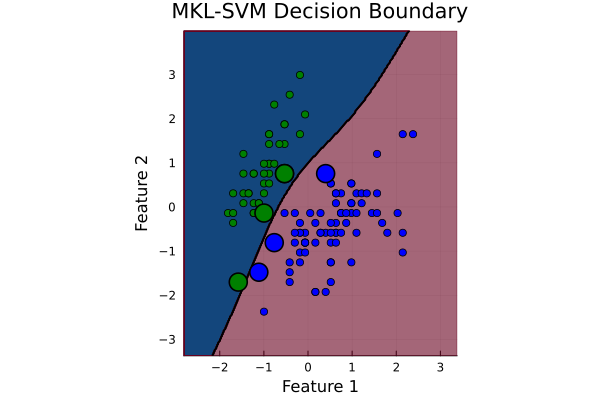

In [12]:
# Define parameters
C = 1
k0 = 3
λ = 1.0 # Regularization for β
sum_beta_val = 10.0
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

# Train MKL-SVM
@time begin
    α, β, K_combined, list_alphas, list_betas = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0, sum_beta_val=sum_beta_val,  
        solver_type=:SMO,   # or LIBSVM, or :SMO or :GUROBI, 
        beta_method=:proximal      # or :hard or :proximal
    )
end



# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

## Next Steps

- speeding up the SVM α sub-problem
- Validation on different datasets
- Benchmark methods that we want to compare against (somewhat recent implemented methods)


## Exploring method in Adult dataset

In [13]:
X_train, y_train, X_test, y_test = get_adult_data()

Filtered dataset summary:
Number of samples: 3256
Number of features: 5
Training set size: 2604
Testing set size: 652
Positive class ratio in training: 0.22542242703533025
Positive class ratio in testing: 0.26226993865030673


([0.32296193789677186 -0.3972790396187721 … 4.411396183297385 -0.06965335826234624; 0.7625052582538421 0.3927283060607107 … -0.2173068018422767 0.3209093999528755; … ; -0.11658138246029835 -3.162304749496962 … -0.2173068018422767 -0.06965335826234624; 2.7404501998606583 1.577739324579935 … -0.2173068018422767 -0.06965335826234624], [1, 1, -1, -1, -1, -1, -1, -1, -1, -1  …  -1, -1, -1, -1, -1, 1, -1, 1, -1, 1], [0.32296193789677186 0.3927283060607107 … -0.2173068018422767 -0.06965335826234624; -0.3363530426388335 1.1827356517401935 … -0.2173068018422767 0.7114721581680973; … ; 0.9822769184323772 1.1827356517401935 … -0.2173068018422767 -0.06965335826234624; -0.8491535830554154 -0.3972790396187721 … -0.2173068018422767 3.0548487074594277], [1, 1, -1, -1, 1, -1, -1, -1, -1, 1  …  -1, 1, -1, 1, -1, -1, -1, -1, 1, 1])

In [14]:
X_train

2604×5 Matrix{Float64}:
  0.322962   -0.397279    -0.14309    4.4114    -0.0696534
  0.762505    0.392728    -0.14309   -0.217307   0.320909
 -0.849154   -0.397279    -0.14309   -0.217307   0.711472
 -0.263096   -0.00227537  -0.14309   -0.217307  -0.0696534
  0.615991   -0.397279    -0.14309   -0.217307  -0.0696534
  2.08114    -0.792283    -0.14309   -0.217307  -1.6319
  1.49508    -2.3723      -0.14309   -0.217307  -0.0696534
 -0.116581   -0.397279    -0.14309   -0.217307   0.477135
 -0.702639   -0.397279    -0.14309   -0.217307  -0.303991
 -1.21544    -0.792283    -0.14309   -0.217307   0.711472
 -1.43521    -0.397279    -0.14309   -0.217307  -0.0696534
  1.49508    -2.7673      -0.14309   -0.217307  -0.0696534
 -0.629382   -2.3723      -0.14309   -0.217307   0.242797
  ⋮                                             
  0.176447   -0.397279    -0.14309   -0.217307  -1.007
 -0.482867    1.18274     -0.14309   -0.217307  -0.0696534
 -1.50847    -1.18729     -0.14309   -0.217307  -0.4602

In [15]:
# Define parameters
C = 1
k0 = 3
λ = 100.0  # Regularization for β
max_iter = 50
sum_beta_val = 1.0
tolerance = 1e-3

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

1.0

In [16]:
using Profile

@time begin
    # Time the train_mkl function
    α, β, K_combined, list_alphas, list_betas = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0, sum_beta_val=sum_beta_val,  
        solver_type=:LIBSVM,   # or LIBSVM, or :SMO or :GUROBI, 
        beta_method=:gssp      #gssp, or :hard or :proximal
    )

    # Compute bias
    b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

    # Predict on training and test data
    y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
    y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

    # Calculate accuracies
    accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
    accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

    # Print accuracies
    println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
    println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")
end

# Print profiling results
# Profile.print()

Iteration 1...
(2604, 2604)
w_sub: [0.19421895419600016, 0.34858813180887965, 0.14103053916237468]
β_sub: [0.299606412473582, 0.4539755900864615, 0.24641799743995652]
β=[0.0, 0.299606412473582, 0.0, 0.4539755900864615, 0.24641799743995652, 0.0]
sum(α)=908.9928483059332
Objective=858.7544063110751
||β - β_old||=0.43579008890209153
Iteration 2...
(2604, 2604)
w_sub: [0.1127088441281376, 0.1662196360289112, 0.06482425228372365]
β_sub: [0.3314579333145468, 0.38496872521532044, 0.28357334147013286]
β=[0.0, 0.3314579333145468, 0.0, 0.38496872521532044, 0.28357334147013286, 0.0]
sum(α)=891.7531037697166
Objective=867.8070974183173
||β - β_old||=0.0845989738071751
Iteration 3...
(2604, 2604)
w_sub: [0.09955467894629118, 0.18415611651703942, 0.07092810122874658]
β_sub: [0.31467504671559876, 0.399276484286347, 0.28604846899805414]
β=[0.0, 0.31467504671559876, 0.0, 0.399276484286347, 0.28604846899805414, 0.0]
sum(α)=892.7521741186831
Objective=867.7230831634802
||β - β_old||=0.022192420068734425


## Gurobi algos

### Test 1 (proximal algo)

Final β: [0.0, 0.20249303467848173, 0.0, 0.2739011179461338, 0.11608233679268697, 0.0]
Final objective function: 879.6251504678511
K_combined_new dimensions: (972, 2604)
K_combined_new dimensions: (972, 652)
Training Accuracy: 83.95%
Test Accuracy: 80.52%
257.706167 seconds (1.23 G allocations: 97.972 GiB, 8.23% gc time)

### Test 2 (gssp)

Final β: [0.0, 0.3194879925245636, 0.0, 0.39591929771166867, 0.2845927097637677, 0.0]
Final objective function: 867.7816879492568
K_combined_new dimensions: (982, 2604)
K_combined_new dimensions: (982, 652)
Training Accuracy: 84.22%
Test Accuracy: 80.37%
230.145202 seconds (1.23 G allocations: 97.965 GiB, 7.92% gc time)


## My algo

### Test 1 (proximal algo)

Final β: [0.0, 0.20153893721170119, 0.0, 0.27435898841943795, 0.116580115519447, 0.0]
Final objective function: 879.5309820151662
K_combined_new dimensions: (969, 2604)
K_combined_new dimensions: (969, 652)
Training Accuracy: 83.95%
Test Accuracy: 80.21%
276.998105 seconds (85.94 M allocations: 4.960 GiB, 0.27% gc time)

### Test 2 (gssp)

Final β: [0.0, 0.31952855729701474, 0.0, 0.3950694731042238, 0.28540196959876146, 0.0]
Final objective function: 867.5933521921302
K_combined_new dimensions: (966, 2604)
K_combined_new dimensions: (966, 652)
Training Accuracy: 84.18%
Test Accuracy: 80.21%
487.379269 seconds (112.14 M allocations: 4.331 GiB, 0.15% gc time)

In [17]:
using Printf

function print_confusion_metrics(y_actual, y_pred, set_name="Data Set")
    println("---------------" * set_name * "---------------")
    println("")
    # Initialize counts
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in 1:length(y_actual)
        actual = y_actual[i]
        predicted = y_pred[i]
        if actual == 1 && predicted == 1
            TP += 1
        elseif actual == -1 && predicted == -1
            TN += 1
        elseif actual == -1 && predicted == 1
            FP += 1
        elseif actual == 1 && predicted == -1
            FN += 1
        end
    end

    # Print confusion matrix
    println("Confusion Matrix ($set_name):")
    println("            Predicted")
    println("            -1     +1")
    println(@sprintf("Actual -1   %-6d %-6d", TN, FP))
    println(@sprintf("       +1   %-6d %-6d", FN, TP))

    # Compute precision, recall, and F1-score
    precision = (TP + FP == 0) ? 0 : TP / (TP + FP)
    recall = (TP + FN == 0) ? 0 : TP / (TP + FN)
    f1_score = (precision + recall == 0) ? 0 : 2 * (precision * recall) / (precision + recall)

    println("Precision: ", precision)
    println("Recall: ", recall)
    println("F1-score: ", f1_score)
    println("")
end

# Example usage:
print_confusion_metrics(y_train, y_pred_train, "Train Set")
print_confusion_metrics(y_test, y_pred_test, "Test Set")

---------------Train Set---------------

Confusion Matrix (Train Set):
            Predicted
            -1     +1
Actual -1   1944   73    
       +1   338    249   
Precision: 0.7732919254658385
Recall: 0.424190800681431
F1-score: 0.5478547854785478

---------------Test Set---------------

Confusion Matrix (Test Set):
            Predicted
            -1     +1
Actual -1   462    19    
       +1   109    62    
Precision: 0.7654320987654321
Recall: 0.36257309941520466
F1-score: 0.4920634920634921



### 

1. Try to use other Julia SVM solver to accelerate algorithm
2. Method 3. for proximal algorithm -> also, see what happens without it
3. Method 2 for dual ascent

## Discussions: 
1. **Normalization of betas at each iteration**: I could only make it work with it
2. **Runtime**: to run the adult dataset, I needed to sample a small part (5%) of data set and took 8min. Do we have any other ideas to speed up or is this normal? 
    - I already did some optimization on the compute_kernels code
    - Ideas: parallelize, run profiler to understand why it is taking so long, etc. 

## Next Steps

- Can be worth taking a look at this sparsePCA -> idea, maybe take out of objective and add a constraint in beta
- profiler seems to be a great idea
- look at other packages for MKL -> see if they have this scalling problem as well
- trying to figure out what optimization problem it is actually solving
- plotting/understanding relationship of lambda and norm(\beta)

## Previous Prioritized Next Steps
- Priority: 1, then 2/3 equally
- We are concerned with run-time. Try to take out gurobi as much as possible. 

1. Sparse Constraints (see trick below from class) **(DONE)**
2. Come up with universe of existing methods that we want to compare with (get papers with Nicholas)
 - Find open source implementation of their code
 - Other methods to solve the multiple kernel learning problem (can be non-sparse), e.g. L1-penalize problem - kind of similar to Lasso
 - No need to implement it
3. Reasonable dataset to test our model (can choose UCI or area I like)